In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical

class ZeroDayIDS:
    def __init__(self, epochs=30, batch_size=32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.scaler = MinMaxScaler()
        self.le = LabelEncoder()

    def load_and_prep(self, clean_data_path):
        print(f"[1/4] Loading Clean Dataset from {clean_data_path}...")
        if not os.path.exists(clean_data_path):
            raise FileNotFoundError("Clean file not found!")

        # 1. Load Full Data (No Sampling)
        df = pd.read_csv(clean_data_path)
        print(f"   Data Loaded: {len(df)} rows")

        # 2. Separate Features & Target
        target_col = 'Label'
        y = df[target_col]
        X = df.drop(target_col, axis=1).select_dtypes(include=[np.number])
        self.num_features = X.shape[1]

        # 3. Scale & Encode
        print("   Scaling Features...")
        X_scaled = self.scaler.fit_transform(X)
        y_encoded = self.le.fit_transform(y)
        self.num_classes = len(self.le.classes_)

        # 4. The 70/30 Split (Teacher's Requirement)
        print("\n[2/4] Splitting Dataset (70% Train / 30% Test)...")
        # We save these as class attributes so we can use them in the next steps
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_scaled, y_encoded,
            train_size=0.70, # 70% Training
            test_size=0.30,  # 30% Testing
            random_state=42,
            stratify=y_encoded
        )
        print(f"   Training Set: {len(self.X_train)} rows")
        print(f"   Testing Set:  {len(self.X_test)} rows")

        # 5. Balance Training Data (ROS)
        print("   Balancing Training Data...")
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(self.X_train, self.y_train)

        # 6. Reshape for CNN
        self.X_train_cnn = X_train_res.reshape((X_train_res.shape[0], self.num_features, 1))
        self.X_test_cnn = self.X_test.reshape((self.X_test.shape[0], self.num_features, 1))

        self.y_train_cat = to_categorical(y_train_res, self.num_classes)
        self.y_test_cat = to_categorical(self.y_test, self.num_classes)

        # Keep raw test labels for the report
        self.y_test_raw = self.y_test

    def build_model(self):
        print("\n[3/4] Building Hybrid CNN-BiLSTM...")
        self.model = Sequential([
            Conv1D(64, 3, activation='relu', padding='same', input_shape=(self.num_features, 1)),
            MaxPooling1D(2),
            Bidirectional(LSTM(64, return_sequences=True)),
            GlobalAveragePooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self):
        print(f"\n[4/4] Training Model (30 Epochs)...")
        # We use the 30% Test Set as Validation to check progress
        self.history = self.model.fit(
            self.X_train_cnn, self.y_train_cat,
            validation_data=(self.X_test_cnn, self.y_test_cat),
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=1
        )

    def generate_report(self, save_dir='results'):
        print("\nGenerating Final Report...")
        if not os.path.exists(save_dir): os.makedirs(save_dir)

        # Curves
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.plot(self.history.history['accuracy']); plt.plot(self.history.history['val_accuracy']); plt.title('Accuracy'); plt.legend(['Train', 'Validation'])
        plt.subplot(1, 2, 2); plt.plot(self.history.history['loss']); plt.plot(self.history.history['val_loss']); plt.title('Loss'); plt.legend(['Train', 'Validation'])
        plt.savefig(f'{save_dir}/training_curves.png')

        # Metrics
        y_pred = np.argmax(self.model.predict(self.X_test_cnn), axis=1)
        unique_labels = np.unique(np.concatenate((self.y_test_raw, y_pred)))
        target_names = self.le.inverse_transform(unique_labels)

        report = classification_report(self.y_test_raw, y_pred, labels=unique_labels, target_names=target_names, digits=4)
        print(report)
        with open(f'{save_dir}/classification_report.txt', 'w') as f: f.write(report)

        # Matrix
        cm = confusion_matrix(self.y_test_raw, y_pred)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.title('Confusion Matrix'); plt.savefig(f'{save_dir}/confusion_matrix.png'); plt.show()

        print(f"✅ DONE. Results saved to '{save_dir}/'")

Mounted at /content/drive
[1/4] Loading Clean Dataset from /content/drive/My Drive/InSDN_Project/InSDN_Cleaned.csv...
   Data Loaded: 307534 rows
   Scaling Features...

[2/4] Splitting Dataset (70% Train / 30% Test)...
   Training Set: 215273 rows
   Testing Set:  92261 rows
   Balancing Training Data...

[3/4] Building Hybrid CNN-BiLSTM...

[4/4] Training Model (30 Epochs)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 846s 40ms/step - accuracy: 0.6976 - loss: 0.7585 - val_accuracy: 0.9741 - val_loss: 0.1098
Epoch 2/30
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 858s 41ms/step - accuracy: 0.9536 - loss: 0.1464 - val_accuracy: 0.9882 - val_loss: 0.0412
Epoch 3/30
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 859s 41ms/step - accuracy: 0.9853 - loss: 0.0541 - val_accuracy: 0.9934 - val_loss: 0.0200
Epoch 4/30
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 864s 41ms/step - accuracy: 0.9895 - loss: 0.0385 - val_accuracy: 0.9948 - val_loss: 0.0217
Epoch 5/30
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 858s 41ms/step - accuracy: 0.9932 - loss: 0.0271 - val_accuracy: 0.9954 - val_loss: 0.0165
Epoch 6/30
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 861s 41ms/step - accuracy: 0.9947 - loss: 0.0215 - val_accuracy: 0.9950 - val_loss: 0.0225
Epoch 7/30
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 861s 41ms/step - accuracy: 0.9960 - loss: 0.0167 - val_accuracy: 0.9981 - val_loss: 0.0094
Epoch 8/30
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 860s 41ms/s

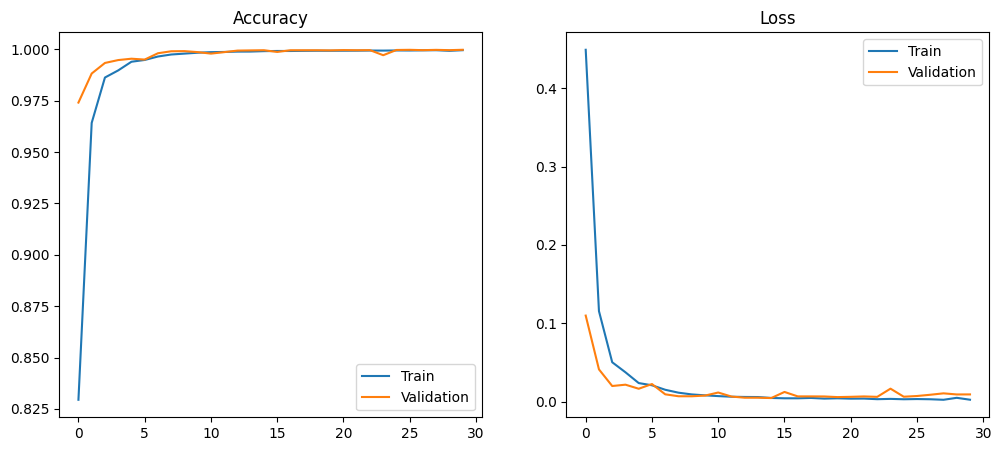

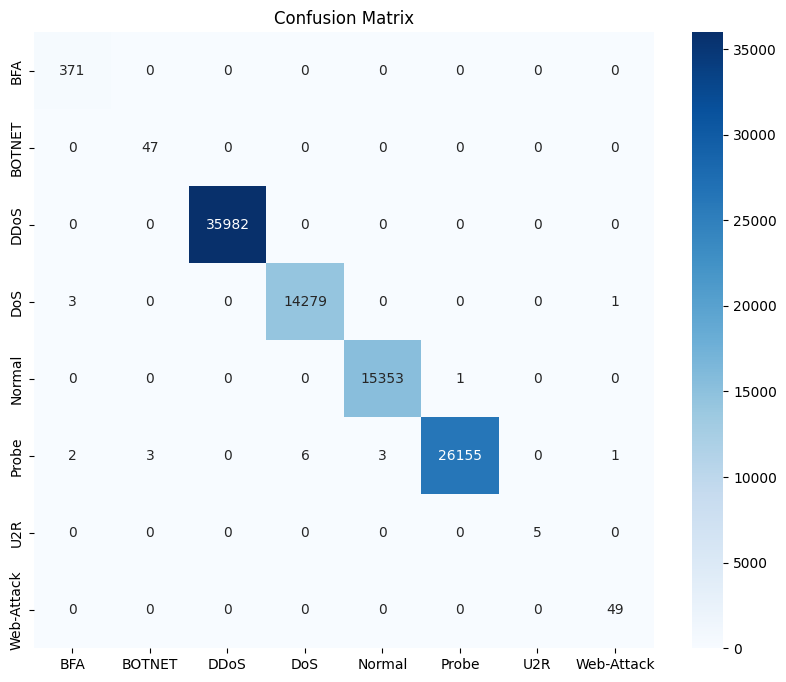

✅ DONE. Results saved to 'results/'


In [ ]:
# 1. Setup
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/InSDN_Project/InSDN_Cleaned.csv'

# 2. Initialize the AI
ids = ZeroDayIDS(epochs=30)

# 3. Execute the Workflow
ids.load_and_prep(path)  # This handles Loading + 70/30 Split
ids.build_model()
ids.train()              # This trains on the 70%
ids.generate_report()    # This tests on the 30%